# Evaluate model metrics metrics

Applys pretrained model to dataset and get performance metrics

0. Load libaries
1. Load model and dataset
2. Run model
3. Run model on test dataset
4. ROC and False Positives
5. Analysis of one given week

## Load libraries 
Install & load python libraries

In [2]:
#pip install tabgan==1.3.3

In [3]:
#!pip install lightgbm

In [4]:
#pip install --upgrade pandas "dask[complete]"

In [5]:
## Libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import re
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
#from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_auc_score
#from scikitplot.metrics import plot_lift_curve
#from scikitplot.helpers import binary_ks_curve 
#from scikitplot.metrics import plot_ks_statistic
#from scikitplot.helpers import cumulative_gain_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from datetime import datetime, timedelta

import pyarrow as pa
import pyarrow.parquet as pq

In [6]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.memory_usage', True)

## Load model and dataset

In [7]:
import os
os.getcwd()

'/root/viamericas-dev/Analytics/5.Fraud'

In [8]:
import os
import joblib
# load model
modelo = joblib.load("ModeloAWSRetrain.pkl") 

In [9]:
modelo

LGBMClassifier(colsample_bytree=0.84, importance_type='gini',
               learning_rate=0.07, max_depth=20, min_child_weight=0.0026,
               n_estimators=520, num_leaves=30, objective='binary',
               scale_pos_weight=0.003, subsample=1)

In [10]:
# Variables names
var_input = ['branch_minutes_since_last_transaction',
    'branch_trans_3m',  'branch_has_fraud',  
    'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_40min', 
    'location_nro_fraud', 'sender_trans_3m', 
    'sender_nro_fraud','a_isMexico', 
    'a_sender_branch_state', 'a_var_range_hist', 
    'a_branch_fraud', 'a_location_fraud',
    'a_isCashPick', 'a_isBankDep', 
    'sender_days_to_last_transaction_more7m', 
    'receiver_transaction_count','a_sender_sending_days',
    'branch_working_days', 'a_net_amount_receiver', 
    'sender_minutes_since_last_transaction_2days', 
    'sender_days_to_last_transaction_365', 
    'sender_days_to_last_transaction_7m', 'a_hour_receiver']

In [11]:
# Load train/validation data
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodosRetrain"
dfTrain = pd.read_parquet(f"s3://{s3_url}/Train/Train.parquet")
tgTrain = dfTrain['target']

dfVal = pd.read_parquet(f"s3://{s3_url}/Validation/Validation.parquet")
tgVal = dfVal['target']

#Uni test y Val
X = pd.concat([dfTrain, dfVal], ignore_index=True) 
Y = pd.DataFrame(pd.concat([dfTrain['target'], dfVal['target']], ignore_index=True)) 

dias_target = ['day_name_receiver_0', 'day_name_receiver_1',
       'day_name_receiver_2', 'day_name_receiver_3',
       'day_name_receiver_4', 'day_name_receiver_5',
       'day_name_receiver_6','target']

testeo =  pd.concat([X, Y], axis=1)
Y_target = pd.DataFrame(pd.concat([dfTrain[dias_target], dfVal[dias_target]], ignore_index=True)) 

## Run model

In [12]:
# Predict using laoded model 
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Get puntuations (predicted probailities) for the positive class (class 1)
probab_rf = modelo.predict_proba(testeo[var_input])

# Extract puntuations (probabilites) for positive class
score_rf = np.delete(probab_rf, np.s_[0], axis=1)

# Create a copy ot the labels for further analysis
Y_c = Y_target.copy()

# Set prediction and puntuationsof model for positive labels
Y_c['preds_rf'] = testeo_data_pred_rf
Y_c['score_rf'] = score_rf

# Divide into tiles and compute cature al 0.02% for train/validation dataset
percentiles = pd.qcut(Y_c['score_rf'], q=1000, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')


In [13]:
pd.crosstab(Y_c['FRAUD_DECILE'], Y_c['target'])

target,False,True
FRAUD_DECILE,,
1,37319,946
2,38260,5
3,38263,1
4,38263,2
5,38263,1
...,...,...
996,38264,0
997,38265,0
998,38264,0


In [14]:
#Get thresold for .01% and 0.2% of data with highest score
corte_02 = Y_c.score_rf[Y_c['FRAUD_DECILE']==2].min()
corte_01 = Y_c.score_rf[Y_c['FRAUD_DECILE']==1].min()
corte = corte_01

<Axes: xlabel='Importance', ylabel='Feature'>

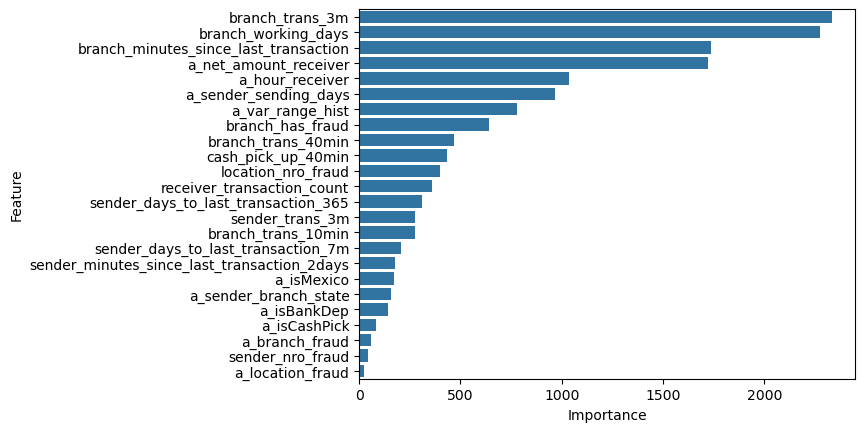

In [15]:
# Plot feature importance using Split
import seaborn as sns
importance = modelo.booster_.feature_importance(importance_type='split')
feature_names = testeo[var_input].columns

# Combine feature names and their importance scores
feature_split = pd.concat((pd.DataFrame(feature_names, columns=['Feature']), pd.DataFrame(importance, columns=['Importance'])),axis=1)
feature_split

sns.barplot(data=feature_split[feature_split['Importance']>0], y='Feature', x ='Importance',
            order=feature_split[feature_split['Importance']>0].sort_values('Importance',ascending = False).Feature)


<Axes: xlabel='Importance', ylabel='Feature'>

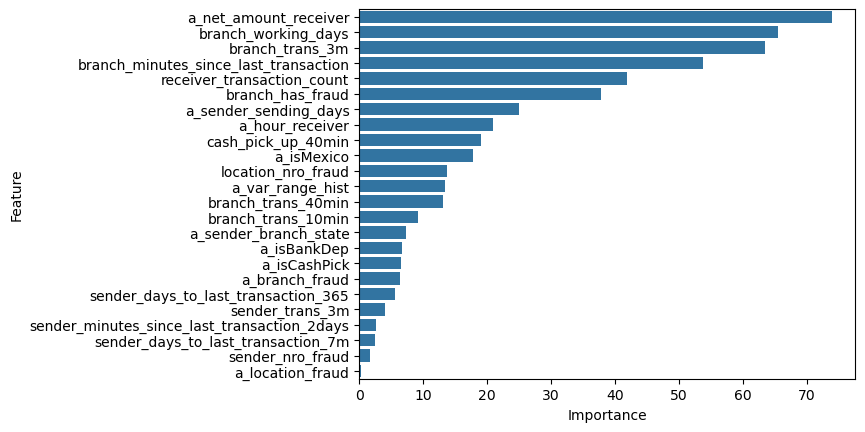

In [16]:
# Plot feature importance using Gain
importance = modelo.booster_.feature_importance(importance_type='gain')

# Combine feature names and their importance scores
feature_gain = pd.concat((pd.DataFrame(feature_names, columns=['Feature']), pd.DataFrame(importance, columns=['Importance'])),axis=1)
feature_gain

sns.barplot(data=feature_gain[feature_gain['Importance']>0], y='Feature', x ='Importance',
            order=feature_gain[feature_gain['Importance']>0].sort_values('Importance',ascending = False).Feature)

In [17]:
# Save feature importance in text file
# Importance is measured in terms of gain according to LightGBM classifier
#np.savetxt('./ModeloFinalImp.txt', modelo.booster_.feature_importance(importance_type='split'),fmt='%f')
#np.savetxt('./ModeloFinalImpG.txt', modelo.booster_.feature_importance(importance_type='gain'),fmt='%f')

## Run model on test dataset

In [18]:
# Load new data to test model
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodosRetrain"
tes = pd.read_parquet(f"s3://{s3_url}/Test/Test.parquet")

## Variable list for input
X = tes[var_input]
Y = tes[['target']]

testeo =  tes.copy()
Y_target = pd.DataFrame(tes[dias_target]) 

In [19]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe

testeo = limpiar_nombres_columnas(testeo)

In [20]:
# target distriution
testeo['target'].value_counts(dropna=False)

target
False    5013233
True          47
Name: count, dtype: int64

In [21]:
# Predict test using trained model
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Get puntuations (predicted probailities) for the positive class (class 1)
probab_rf = modelo.predict_proba(testeo[var_input])

# Extract puntuations (probabilites) for positive class
# Assumes that second column has probabilites for positive class
score_rf = np.delete(probab_rf, np.s_[0], axis=1)


In [22]:
# Create a copy DataFrame 'Y_TESTEO' to preserve original data and save prediction and score
Y_c = Y_target.copy()

Y_c['preds_rf'] = testeo_data_pred_rf
Y_c['score_rf'] = score_rf

In [23]:
# Set threshold for positive class
corte = corte_01
Y_c['pred_corte'] = Y_c['score_rf']>corte
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['pred_corte']))

,0,1
0,5010779,2454
1,22,25


In [24]:
# Divide into tiles and analize scores for test dataset
percentiles = pd.qcut(Y_c['score_rf'], q=1000, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')
print('FRAUD CAPTURA .20%:')
print(sum(Y_c[Y_c['FRAUD_DECILE'] < 2]['target']) / sum(Y_c['target']))

FRAUD CAPTURA .20%:
0.574468085106383


In [25]:
pd.crosstab(Y_c['FRAUD_DECILE'], Y_c['pred_corte'])

pred_corte,False,True
FRAUD_DECILE,,
1,2535,2479
2,5013,0
3,5013,0
4,5014,0
5,5013,0
...,...,...
996,5013,0
997,5014,0
998,5013,0


In [26]:
DECILES = pd.crosstab(Y_c['FRAUD_DECILE'], Y_c['target'])
DECILES

target,False,True
FRAUD_DECILE,,
1,4987,27
2,5010,3
3,5010,3
4,5012,2
5,5013,0
...,...,...
996,5013,0
997,5014,0
998,5013,0


In [27]:
Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': [ 'min', 'max']}) 

score_rf              
                       min           max
FRAUD_DECILE                            
1             9.195645e-07  9.999980e-01
2             3.528116e-07  9.192922e-07
3             2.005952e-07  3.527932e-07
4             1.327878e-07  2.005865e-07
5             9.651335e-08  1.327811e-07
...                    ...           ...
996           1.276438e-13  1.418043e-13
997           1.126378e-13  1.276348e-13
998           9.577509e-14  1.126374e-13
999           7.417612e-14  9.576380e-14
1000          1.292466e-14  7.417060e-14

[1000 rows x 2 columns]

In [28]:
#See false positives by month
tes_corte = testeo[Y_c['pred_corte']==True]
Y_c_corte = Y_c[Y_c['pred_corte']==True]

pd.crosstab(tes_corte['date_receiver'].dt.month, Y_c_corte['target'])

target,False,True
date_receiver,,
6,1693,16
7,761,9


In [29]:
Y_c_corte.count()

day_name_receiver_0    2479
day_name_receiver_1    2479
day_name_receiver_2    2479
day_name_receiver_3    2479
day_name_receiver_4    2479
day_name_receiver_5    2479
day_name_receiver_6    2479
target                 2479
preds_rf               2479
score_rf               2479
pred_corte             2479
FRAUD_DECILE           2479
dtype: int64

In [30]:
# target distribution by month
pd.crosstab(testeo['date_receiver'].dt.month, Y_c['target'])

target,False,True
date_receiver,,
6,2701312,22
7,2311921,25


In [31]:
# alerts by day of the week
deciles_semana = Y_c[['day_name_receiver_0', 'day_name_receiver_1',
                   'day_name_receiver_2', 'day_name_receiver_3',
                   'day_name_receiver_4', 'day_name_receiver_5',
                   'day_name_receiver_6',
                 'FRAUD_DECILE']].groupby(['FRAUD_DECILE']).sum()

deciles_semana.head(10)

,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6
FRAUD_DECILE,,,,,,,
1,837,713,616,536,678,877,757
2,793,708,668,585,687,829,743
3,766,703,667,523,696,903,755
4,817,731,592,568,665,823,818
5,799,695,594,541,667,902,815
6,784,673,634,513,699,923,787
7,829,668,632,504,659,888,833
8,808,673,615,510,694,902,812
9,760,685,667,474,695,896,836


## ROC curve and FP

In [32]:
#pip install scikit-plot

In [33]:
%pip install scipy==1.11.4

  Using cached scipy-1.11.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached scipy-1.11.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (36.4 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.0
    Uninstalling scipy-1.13.0:
      Successfully uninstalled scipy-1.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sagemaker-datawrangler 0.4.3 requires sagemaker-data-insights==0.4.0, but you have sagemaker-data-insights 0.3.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [34]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_lift_curve
from scikitplot.helpers import binary_ks_curve
from scikitplot.metrics import plot_ks_statistic
from scikitplot.helpers import cumulative_gain_curve

ModuleNotFoundError: No module named 'scikitplot'

In [ ]:
# Gain curve and LIFT for data
classes = np.unique(Y_c[['target']])
percentages, gains = cumulative_gain_curve(Y_c[['target']], Y_c['score_rf'], classes[1])
percentages = percentages[1:]
gains = gains[1:]
gains = gains / percentages
indice = round(len(gains) * 0.1)
print('LIFT FRAUD TESTEO:')
print(gains[indice])

# ROC curve for dataset
print('ROC FRAUD TESTEO:')
print(roc_auc_score(Y_c[['target']], Y_c['preds_rf']))

# KS statistic for data
thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(Y_c[['target']], Y_c['score_rf'])
print('KS FRAUD TESTEO:')
print(ks_statistic)

# Presicion and recall for dataset
precision = precision_score(Y_c[['target']], Y_c['preds_rf'])
recall = recall_score(Y_c[['target']], Y_c['preds_rf'])
print('Precision FRAUD TESTEO:')
print(precision)
print('Recall FRAUD TESTEO:')
print(recall)

In [ ]:
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_true=Y_c[['target']], y_probas =  probab_rf)
plt.show()

In [ ]:
from sklearn.metrics import RocCurveDisplay, roc_curve

fpr, tpr, _ = roc_curve(Y_c[['target']], score_rf)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [ ]:
#precision, recall, thresholds = skplt.metrics.precision_recall_curve(Y_c[['target']], score_rf)
#plt.plot(precision, recall)

## Analysis of one given week
Choose a week for in depth analysis

In [ ]:
# set week limits
week_testigo = tes['date_receiver'].between('2024-04-22','2024-04-29')
X_week_testigo = tes[week_testigo]
Y_c_week_testigo = Y_c[week_testigo]

week_testigo.sum(), X_week_testigo.shape, Y_c_week_testigo.shape

In [ ]:
pd.crosstab(X_week_testigo['date_receiver'].dt.day, Y_c_week_testigo['target'])

In [ ]:
#False positives for threshold
X_week_testigo_corte = X_week_testigo[Y_c_week_testigo['pred_corte']==True]
Y_c_week_testigo_corte = Y_c_week_testigo[Y_c_week_testigo['pred_corte']==True]

pd.crosstab(X_week_testigo_corte['date_receiver'].dt.day, Y_c_week_testigo_corte['target'])

In [ ]:
Tabla_Week = pd.DataFrame(pd.concat([X_week_testigo['date_receiver'].dt.day,X_week_testigo['fraud_classification'], 
                                     Y_c_week_testigo['FRAUD_DECILE'], Y_c_week_testigo['target']],axis=1))

In [ ]:
Tabla_Week[Tabla_Week['target']==True]
pd.crosstab(Tabla_Week.date_receiver, Tabla_Week.FRAUD_DECILE)

In [ ]:
pd.crosstab(Tabla_Week.date_receiver[Tabla_Week['target']==True], Tabla_Week.FRAUD_DECILE[Tabla_Week['target']==True])

In [ ]:
Tabla_Week.loc[Tabla_Week['target']==True,['date_receiver','fraud_classification','FRAUD_DECILE']]